In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from collections import Counter
from transformers import AutoConfig
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
EOSINOPHIL_PATH = '/kaggle/input/white-blood-cell-dataset/data/EOSINOPHIL/*.jpg'
LYMPHOCYTE_PATH = '/kaggle/input/white-blood-cell-dataset/data/LYMPHOCYTE/*.jpg'
MONOCYTE_PATH = '/kaggle/input/white-blood-cell-dataset/data/MONOCYTE/*.jpg'
NEUTROPHIL_PATH = '/kaggle/input/white-blood-cell-dataset/data/NEUTROPHIL/*.jpg'

EOSINOPHIL_LABEL = 0
LYMPHOCYTE_LABEL = 1
MONOCYTE_LABEL   = 2
NEUTROPHIL_LABEL = 3

In [3]:
CELL_TYPES = {
    "EOSINOPHIL": 0,
    "LYMPHOCYTE": 1,
    "MONOCYTE": 2,
    "NEUTROPHIL": 3
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class Data(Dataset):
    def __init__(self, img_size_w=224, img_size_h=224, up_sample=True, mode='train'):
        self.img_size_w = img_size_w
        self.img_size_h = img_size_h
        self.mode = mode

        self.load_data(up_sample)
        self.split_data()

    def set_mode(self, mode):
        self.mode = mode

    def set_transformers(self, train_transform=None, val_transform=None):
        self.train_transform = train_transform
        self.val_transform = val_transform

    def split_data(self):
        X_train, X_val, y_train, y_val = train_test_split(self.images, self.labels, test_size=0.1, random_state=42)

        self.X_train, self.y_train = X_train, y_train
        self.X_val,   self.y_val   = X_val,   y_val

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_val[idx], self.y_val[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images / 255.0

    def load_from_dataset(self, path):
        data = []
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size_w, self.img_size_h))
            data.append(img)
        return data

    def load_data(self, up_sample):
        eosinophil = self.load_from_dataset(EOSINOPHIL_PATH)
        lymphocyte = self.load_from_dataset(LYMPHOCYTE_PATH)
        monocyte   = self.load_from_dataset(MONOCYTE_PATH)
        neutrophil = self.load_from_dataset(NEUTROPHIL_PATH)

        eosinophil = np.array(eosinophil, dtype=np.float32)
        lymphocyte = np.array(lymphocyte, dtype=np.float32)
        monocyte   = np.array(monocyte,   dtype=np.float32)
        neutrophil = np.array(neutrophil, dtype=np.float32)

        print(f'dataset shape is : {monocyte.shape}')

        eosinophil_labels = np.full(eosinophil.shape[0], CELL_TYPES["EOSINOPHIL"])
        lymphocyte_labels = np.full(lymphocyte.shape[0], CELL_TYPES["LYMPHOCYTE"])
        monocyte_labels   = np.full(monocyte.shape[0],   CELL_TYPES["MONOCYTE"])
        neutrophil_labels = np.full(neutrophil.shape[0], CELL_TYPES["NEUTROPHIL"])

        images = (eosinophil, lymphocyte, monocyte, neutrophil)
        labels = (eosinophil_labels, lymphocyte_labels, monocyte_labels, neutrophil_labels)
        self.images = np.concatenate(images, axis=0)
        self.labels = np.concatenate(labels, axis=0)

        self.show_sample_images([eosinophil[0], lymphocyte[0], monocyte[0], neutrophil[0]])
        self.plot_label_distribution() 

        if up_sample:
            self.upsample_data()

        # self.show_sample_images([eosinophil[0], lymphocyte[0], monocyte[0], neutrophil[0]])

    def upsample_data(self):
        label_counts = Counter(self.labels)
        max_count = max(label_counts.values())

        augmented_images = []
        augmented_labels = []

        augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop((self.img_size_w, self.img_size_h)),
            transforms.ToTensor()
        ])

        for label, count in label_counts.items():
            if count < max_count:
                deficit = max_count - count
                indices = np.where(self.labels == label)[0]
                for _ in range(deficit):
                    idx = np.random.choice(indices)
                    img = self.images[idx].astype(np.uint8)
                    img_aug = augmentation(img).numpy().transpose(1, 2, 0) * 255
                    augmented_images.append(img_aug)
                    augmented_labels.append(label)

        self.images = np.concatenate((self.images, np.array(augmented_images, dtype=np.float32)), axis=0)
        self.labels = np.concatenate((self.labels, np.array(augmented_labels, dtype=np.float32)), axis=0)

    def show_sample_images(self, sample_images):
        reverse_cell_types = {v: k for k, v in CELL_TYPES.items()}
        plt.figure(figsize=(10, 10))
        for i in range(len(sample_images)):
            plt.subplot(1, len(sample_images), i + 1)
            plt.imshow(sample_images[i].astype('uint8'))
            plt.title(f'Label: {reverse_cell_types.get(i, "Unknown")}')
            plt.axis('off')

    def plot_label_distribution(self):
        label_counts = {k: np.sum(self.labels == v) for k, v in CELL_TYPES.items()}
        plt.figure(figsize=(10, 5))
        plt.bar(label_counts.keys(), label_counts.values())
        plt.xlabel('Cell Type')
        plt.ylabel('Count')
        plt.title('Distribution of Cell Types in Dataset')


dataset shape is : (20, 224, 224, 3)


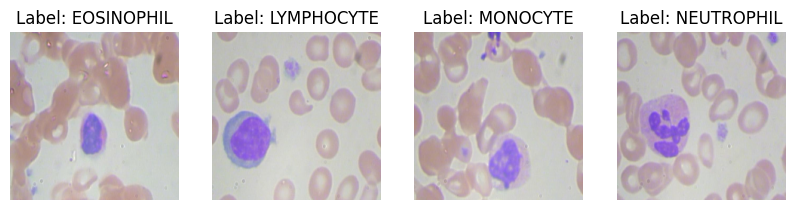

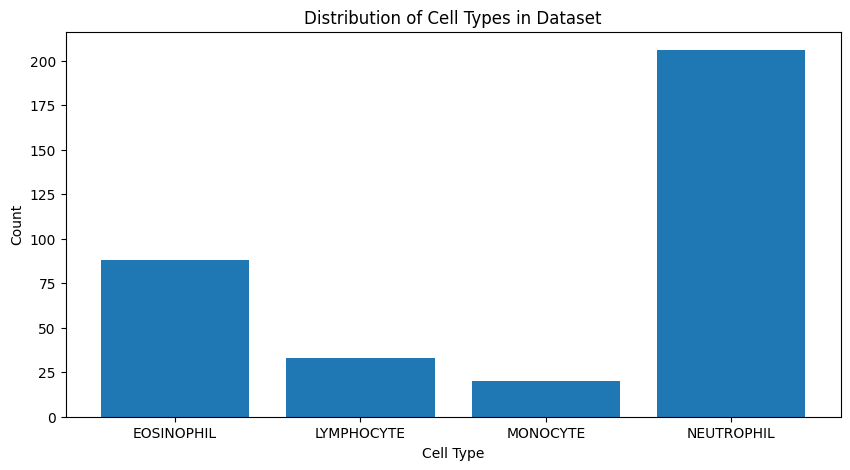

In [6]:
dataset = Data(img_size_w=224, img_size_h=224)
dataset.set_transformers(
    train_transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]),
    val_transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
)

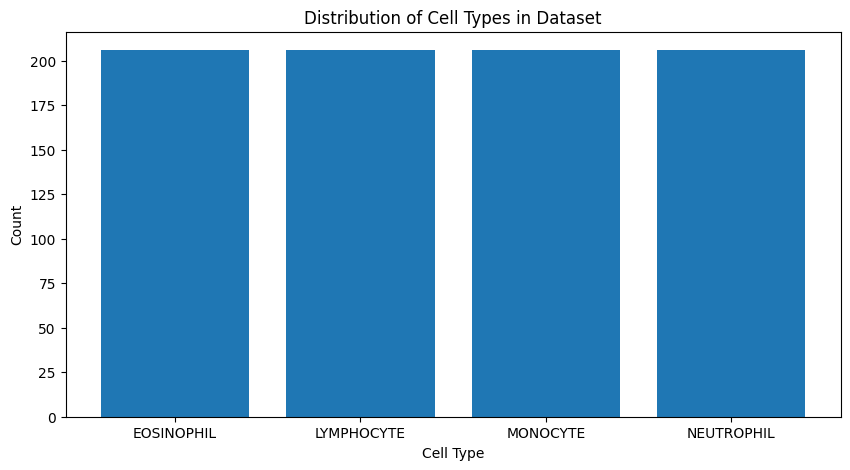

In [7]:
dataset.plot_label_distribution()

In [8]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [9]:
def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return {
        "Total Parameters": total_params,
        "Trainable Parameters": trainable_params
    }

In [10]:
def load_model():
    model_name = "google/vit-base-patch16-224"
    model = ViTForImageClassification.from_pretrained(model_name, num_labels=4, ignore_mismatched_sizes=True)  # Adjust num_labels as needed
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    return model, feature_extractor

In [11]:
def method_1():
    model, feature_extractor = load_model()
    for param in model.parameters():
        param.requires_grad = False 
    for param in model.classifier.parameters():
        param.requires_grad = True 
    
    # print("Trainable Parameters:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)
    
    model_params_count = count_model_parameters(model)
    print("Model Parameters Count:", model_params_count)
    
    train_model(
        model, train_loader, val_loader, 
        epochs=100, learning_rate=3e-4, 
        dataset=dataset, model_name="VIT",
        patience=18, scheduler_patience=5, 
        save_path="best_VIT1.pth"
    )

In [12]:
def method_2():
    model, feature_extractor = load_model()
    
    for param in model.parameters():
        param.requires_grad = False
    
    for layer_index, layer in enumerate(model.vit.encoder.layer):
        if layer_index < 2:
            for param in layer.parameters():
                param.requires_grad = True
    
    model_params_count = count_model_parameters(model)
    print("Model Parameters Count:", model_params_count)
    
    train_model(
        model, train_loader, val_loader, 
        epochs=100, learning_rate=3e-4, 
        dataset=dataset, model_name="VIT",
        patience=18, scheduler_patience=5, 
        save_path="best_VIT2.pth"
    )


In [13]:
def method_3():
    model, feature_extractor = load_model()
    
    for param in model.parameters():
        param.requires_grad = False
    
    # Assuming model.vit.encoder.layer contains the transformer layers
    num_layers = len(model.vit.encoder.layer)
    for i in range(num_layers - 2, num_layers):
        for param in model.vit.encoder.layer[i].parameters():
            param.requires_grad = True

    model_params_count = count_model_parameters(model)
    print("Model Parameters Count:", model_params_count)
    
    train_model(
        model, train_loader, val_loader, 
        epochs=100, learning_rate=3e-4, 
        dataset=dataset, model_name="VIT",
        patience=18, scheduler_patience=5, 
        save_path="best_VIT3.pth"
    )

In [14]:
def train_model(
    model, train_loader, val_loader, epochs, learning_rate, dataset, model_name, 
    patience=-1, scheduler_patience=-1, save_path="best_model.pth"
):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    model.to(device)

    # Early stopping variables
    best_val_acc = 0
    early_stop_counter = 0

    for epoch in range(epochs):
        dataset.set_mode('train')
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        with tqdm(train_loader, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                if model_name == "VIT":
                    outputs = model(images)['logits']
                else:
                    outputs = model(images)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels.long()).sum().item()
                total_train += labels.size(0)

                tepoch.set_postfix(loss=loss.item())

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        dataset.set_mode('val')
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                if model_name == "VIT":
                    outputs = model(images)['logits']
                else:
                    outputs = model(images)
                loss = criterion(outputs, labels.long())
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels.long()).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}, LearningRate: {optimizer.param_groups[0]['lr']}")

        # Early stopping logic
        if patience > 0:
            if val_accuracies[-1] > best_val_acc:
                best_val_acc = val_accuracies[-1]
                early_stop_counter = 0
                torch.save(model.state_dict(), save_path)  # Save the best model
                print(f"Model saved at epoch {epoch + 1}")
            else:
                early_stop_counter += 1
                print(f"Early stop counter: {early_stop_counter}/{patience}")
                if early_stop_counter > patience:
                    print("Early stopping triggered!")
                    model.load_state_dict(torch.load(save_path))  # Load the best model
                    break
                elif scheduler_patience != -1:
                    if early_stop_counter % scheduler_patience == 0:
                        last_lr = optimizer.param_groups[0]['lr']
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = last_lr * 0.5
                        print(f"Learningrate changed from : {last_lr} to {last_lr * 0.5}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss During Training")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy During Training")
    plt.legend()
    plt.show()

    return model

In [15]:
def method_4():
    model, feature_extractor = load_model()
    for param in model.parameters():
        param.requires_grad = True

    model_params_count = count_model_parameters(model)
    print("Model Parameters Count:", model_params_count)
    
    train_model(
        model, train_loader, val_loader, 
        epochs=100, learning_rate=3e-4, 
        dataset=dataset, model_name="VIT",
        patience=18, scheduler_patience=5, 
        save_path="best_VIT4.pth"
    )

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model Parameters Count: {'Total Parameters': 85801732, 'Trainable Parameters': 3076}


Epoch 1: 100%|██████████| 12/12 [00:10<00:00,  1.14batch/s, loss=1.54]


Epoch 1/100 - Train Loss: 1.5464, Train Acc: 0.2159, Val Loss: 1.4545, Val Acc: 0.2771, LearningRate: 0.0003
Model saved at epoch 1


Epoch 2: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=1.41]


Epoch 2/100 - Train Loss: 1.4097, Train Acc: 0.2969, Val Loss: 1.4114, Val Acc: 0.3133, LearningRate: 0.0003
Model saved at epoch 2


Epoch 3: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=1.33]


Epoch 3/100 - Train Loss: 1.3035, Train Acc: 0.3927, Val Loss: 1.3538, Val Acc: 0.3614, LearningRate: 0.0003
Model saved at epoch 3


Epoch 4: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.24]


Epoch 4/100 - Train Loss: 1.2599, Train Acc: 0.4170, Val Loss: 1.3421, Val Acc: 0.3735, LearningRate: 0.0003
Model saved at epoch 4


Epoch 5: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=1.28]


Epoch 5/100 - Train Loss: 1.2332, Train Acc: 0.4359, Val Loss: 1.3314, Val Acc: 0.3614, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 6: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.12]


Epoch 6/100 - Train Loss: 1.1875, Train Acc: 0.4777, Val Loss: 1.2777, Val Acc: 0.3976, LearningRate: 0.0003
Model saved at epoch 6


Epoch 7: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.06]


Epoch 7/100 - Train Loss: 1.1700, Train Acc: 0.4737, Val Loss: 1.2935, Val Acc: 0.3735, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 8: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=1.11]


Epoch 8/100 - Train Loss: 1.1401, Train Acc: 0.4858, Val Loss: 1.2577, Val Acc: 0.3976, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 9: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.01]


Epoch 9/100 - Train Loss: 1.1091, Train Acc: 0.5304, Val Loss: 1.2556, Val Acc: 0.3976, LearningRate: 0.0003
Early stop counter: 3/18


Epoch 10: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.07]


Epoch 10/100 - Train Loss: 1.0901, Train Acc: 0.5574, Val Loss: 1.2403, Val Acc: 0.4217, LearningRate: 0.0003
Model saved at epoch 10


Epoch 11: 100%|██████████| 12/12 [00:09<00:00,  1.20batch/s, loss=0.889]


Epoch 11/100 - Train Loss: 1.0841, Train Acc: 0.5587, Val Loss: 1.2521, Val Acc: 0.4217, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 12: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.14] 


Epoch 12/100 - Train Loss: 1.0678, Train Acc: 0.5587, Val Loss: 1.2312, Val Acc: 0.4458, LearningRate: 0.0003
Model saved at epoch 12


Epoch 13: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.01] 


Epoch 13/100 - Train Loss: 1.0357, Train Acc: 0.5816, Val Loss: 1.1972, Val Acc: 0.4578, LearningRate: 0.0003
Model saved at epoch 13


Epoch 14: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.927]


Epoch 14/100 - Train Loss: 1.0132, Train Acc: 0.5951, Val Loss: 1.1983, Val Acc: 0.4337, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 15: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.05] 


Epoch 15/100 - Train Loss: 1.0033, Train Acc: 0.6032, Val Loss: 1.2045, Val Acc: 0.4458, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 16: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.08]


Epoch 16/100 - Train Loss: 1.0180, Train Acc: 0.5965, Val Loss: 1.1654, Val Acc: 0.4699, LearningRate: 0.0003
Model saved at epoch 16


Epoch 17: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=1.13]


Epoch 17/100 - Train Loss: 1.0022, Train Acc: 0.6100, Val Loss: 1.1814, Val Acc: 0.4699, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 18: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=1.04]


Epoch 18/100 - Train Loss: 0.9845, Train Acc: 0.5857, Val Loss: 1.1494, Val Acc: 0.5181, LearningRate: 0.0003
Model saved at epoch 18


Epoch 19: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=1]    


Epoch 19/100 - Train Loss: 1.0137, Train Acc: 0.5722, Val Loss: 1.1215, Val Acc: 0.5422, LearningRate: 0.0003
Model saved at epoch 19


Epoch 20: 100%|██████████| 12/12 [00:09<00:00,  1.21batch/s, loss=0.946]


Epoch 20/100 - Train Loss: 0.9649, Train Acc: 0.5924, Val Loss: 1.1260, Val Acc: 0.5422, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 21: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.988]


Epoch 21/100 - Train Loss: 0.9515, Train Acc: 0.6383, Val Loss: 1.0811, Val Acc: 0.5542, LearningRate: 0.0003
Model saved at epoch 21


Epoch 22: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.958]


Epoch 22/100 - Train Loss: 0.9555, Train Acc: 0.6140, Val Loss: 1.0818, Val Acc: 0.5663, LearningRate: 0.0003
Model saved at epoch 22


Epoch 23: 100%|██████████| 12/12 [00:09<00:00,  1.21batch/s, loss=0.969]


Epoch 23/100 - Train Loss: 0.9226, Train Acc: 0.6653, Val Loss: 1.0641, Val Acc: 0.5542, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 24: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=0.972]


Epoch 24/100 - Train Loss: 0.9330, Train Acc: 0.6248, Val Loss: 1.0646, Val Acc: 0.5422, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 25: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.795]


Epoch 25/100 - Train Loss: 0.9203, Train Acc: 0.6316, Val Loss: 1.0880, Val Acc: 0.5181, LearningRate: 0.0003
Early stop counter: 3/18


Epoch 26: 100%|██████████| 12/12 [00:09<00:00,  1.21batch/s, loss=0.847]


Epoch 26/100 - Train Loss: 0.9275, Train Acc: 0.6248, Val Loss: 0.9983, Val Acc: 0.6024, LearningRate: 0.0003
Model saved at epoch 26


Epoch 27: 100%|██████████| 12/12 [00:09<00:00,  1.24batch/s, loss=0.818]


Epoch 27/100 - Train Loss: 0.8965, Train Acc: 0.6464, Val Loss: 1.0456, Val Acc: 0.5783, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 28: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.9]  


Epoch 28/100 - Train Loss: 0.8926, Train Acc: 0.6572, Val Loss: 1.0124, Val Acc: 0.5783, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 29: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=0.782]


Epoch 29/100 - Train Loss: 0.8902, Train Acc: 0.6572, Val Loss: 1.0014, Val Acc: 0.5904, LearningRate: 0.0003
Early stop counter: 3/18


Epoch 30: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=1]    


Epoch 30/100 - Train Loss: 0.8893, Train Acc: 0.6505, Val Loss: 0.9898, Val Acc: 0.6265, LearningRate: 0.0003
Model saved at epoch 30


Epoch 31: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.854]


Epoch 31/100 - Train Loss: 0.8966, Train Acc: 0.6343, Val Loss: 0.9712, Val Acc: 0.5663, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 32: 100%|██████████| 12/12 [00:09<00:00,  1.21batch/s, loss=0.769]


Epoch 32/100 - Train Loss: 0.8933, Train Acc: 0.6437, Val Loss: 0.9752, Val Acc: 0.6265, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 33: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.923]


Epoch 33/100 - Train Loss: 0.8769, Train Acc: 0.6856, Val Loss: 0.9735, Val Acc: 0.6265, LearningRate: 0.0003
Early stop counter: 3/18


Epoch 34: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.905]


Epoch 34/100 - Train Loss: 0.8723, Train Acc: 0.6734, Val Loss: 0.9886, Val Acc: 0.5663, LearningRate: 0.0003
Early stop counter: 4/18


Epoch 35: 100%|██████████| 12/12 [00:10<00:00,  1.19batch/s, loss=0.8]  


Epoch 35/100 - Train Loss: 0.8511, Train Acc: 0.6761, Val Loss: 0.9592, Val Acc: 0.6265, LearningRate: 0.0003
Early stop counter: 5/18
Learningrate changed from : 0.0003 to 0.00015


Epoch 36: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.767]


Epoch 36/100 - Train Loss: 0.8510, Train Acc: 0.6734, Val Loss: 0.9596, Val Acc: 0.6386, LearningRate: 0.00015
Model saved at epoch 36


Epoch 37: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.942]


Epoch 37/100 - Train Loss: 0.8608, Train Acc: 0.6680, Val Loss: 0.9636, Val Acc: 0.6145, LearningRate: 0.00015
Early stop counter: 1/18


Epoch 38: 100%|██████████| 12/12 [00:09<00:00,  1.20batch/s, loss=0.857]


Epoch 38/100 - Train Loss: 0.8633, Train Acc: 0.6640, Val Loss: 0.9549, Val Acc: 0.6145, LearningRate: 0.00015
Early stop counter: 2/18


Epoch 39: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=1.05] 


Epoch 39/100 - Train Loss: 0.8741, Train Acc: 0.6640, Val Loss: 0.9643, Val Acc: 0.5904, LearningRate: 0.00015
Early stop counter: 3/18


Epoch 40: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.772]


Epoch 40/100 - Train Loss: 0.8429, Train Acc: 0.6842, Val Loss: 0.9435, Val Acc: 0.6145, LearningRate: 0.00015
Early stop counter: 4/18


Epoch 41: 100%|██████████| 12/12 [00:10<00:00,  1.17batch/s, loss=0.782]


Epoch 41/100 - Train Loss: 0.8495, Train Acc: 0.6559, Val Loss: 0.9368, Val Acc: 0.6386, LearningRate: 0.00015
Early stop counter: 5/18
Learningrate changed from : 0.00015 to 7.5e-05


Epoch 42: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.936]


Epoch 42/100 - Train Loss: 0.8454, Train Acc: 0.6748, Val Loss: 0.9434, Val Acc: 0.6265, LearningRate: 7.5e-05
Early stop counter: 6/18


Epoch 43: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=0.751]


Epoch 43/100 - Train Loss: 0.8263, Train Acc: 0.6694, Val Loss: 0.9351, Val Acc: 0.6386, LearningRate: 7.5e-05
Early stop counter: 7/18


Epoch 44: 100%|██████████| 12/12 [00:10<00:00,  1.20batch/s, loss=0.671]


Epoch 44/100 - Train Loss: 0.8235, Train Acc: 0.6842, Val Loss: 0.9288, Val Acc: 0.6386, LearningRate: 7.5e-05
Early stop counter: 8/18


Epoch 45: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=0.938]


Epoch 45/100 - Train Loss: 0.8586, Train Acc: 0.6586, Val Loss: 0.9339, Val Acc: 0.6506, LearningRate: 7.5e-05
Model saved at epoch 45


Epoch 46: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=0.818]


Epoch 46/100 - Train Loss: 0.8214, Train Acc: 0.6748, Val Loss: 0.9252, Val Acc: 0.6747, LearningRate: 7.5e-05
Model saved at epoch 46


Epoch 47: 100%|██████████| 12/12 [00:09<00:00,  1.20batch/s, loss=0.691]


Epoch 47/100 - Train Loss: 0.8186, Train Acc: 0.6964, Val Loss: 0.9317, Val Acc: 0.6627, LearningRate: 7.5e-05
Early stop counter: 1/18


Epoch 48: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.678]


Epoch 48/100 - Train Loss: 0.8533, Train Acc: 0.6586, Val Loss: 0.9449, Val Acc: 0.6265, LearningRate: 7.5e-05
Early stop counter: 2/18


Epoch 49: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.824]


Epoch 49/100 - Train Loss: 0.8326, Train Acc: 0.6626, Val Loss: 0.9466, Val Acc: 0.6024, LearningRate: 7.5e-05
Early stop counter: 3/18


Epoch 50: 100%|██████████| 12/12 [00:10<00:00,  1.20batch/s, loss=0.988]


Epoch 50/100 - Train Loss: 0.8596, Train Acc: 0.6586, Val Loss: 0.9428, Val Acc: 0.6265, LearningRate: 7.5e-05
Early stop counter: 4/18


Epoch 51: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.892]


Epoch 51/100 - Train Loss: 0.8468, Train Acc: 0.6572, Val Loss: 0.9372, Val Acc: 0.6386, LearningRate: 7.5e-05
Early stop counter: 5/18
Learningrate changed from : 7.5e-05 to 3.75e-05


Epoch 52: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.638]


Epoch 52/100 - Train Loss: 0.8236, Train Acc: 0.6572, Val Loss: 0.9330, Val Acc: 0.6386, LearningRate: 3.75e-05
Early stop counter: 6/18


Epoch 53: 100%|██████████| 12/12 [00:10<00:00,  1.18batch/s, loss=0.772]


Epoch 53/100 - Train Loss: 0.8404, Train Acc: 0.6775, Val Loss: 0.9321, Val Acc: 0.6386, LearningRate: 3.75e-05
Early stop counter: 7/18


Epoch 54: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.794]


Epoch 54/100 - Train Loss: 0.8441, Train Acc: 0.6748, Val Loss: 0.9340, Val Acc: 0.6386, LearningRate: 3.75e-05
Early stop counter: 8/18


Epoch 55: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.789]


Epoch 55/100 - Train Loss: 0.8325, Train Acc: 0.6572, Val Loss: 0.9328, Val Acc: 0.6627, LearningRate: 3.75e-05
Early stop counter: 9/18


Epoch 56: 100%|██████████| 12/12 [00:09<00:00,  1.20batch/s, loss=0.746]


Epoch 56/100 - Train Loss: 0.8437, Train Acc: 0.6856, Val Loss: 0.9341, Val Acc: 0.6265, LearningRate: 3.75e-05
Early stop counter: 10/18
Learningrate changed from : 3.75e-05 to 1.875e-05


Epoch 57: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=0.817]


Epoch 57/100 - Train Loss: 0.8346, Train Acc: 0.6734, Val Loss: 0.9337, Val Acc: 0.6386, LearningRate: 1.875e-05
Early stop counter: 11/18


Epoch 58: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.794]


Epoch 58/100 - Train Loss: 0.8456, Train Acc: 0.6491, Val Loss: 0.9348, Val Acc: 0.6265, LearningRate: 1.875e-05
Early stop counter: 12/18


Epoch 59: 100%|██████████| 12/12 [00:09<00:00,  1.21batch/s, loss=0.849]


Epoch 59/100 - Train Loss: 0.8439, Train Acc: 0.6694, Val Loss: 0.9338, Val Acc: 0.6265, LearningRate: 1.875e-05
Early stop counter: 13/18


Epoch 60: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.963]


Epoch 60/100 - Train Loss: 0.8404, Train Acc: 0.6640, Val Loss: 0.9334, Val Acc: 0.6386, LearningRate: 1.875e-05
Early stop counter: 14/18


Epoch 61: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.749]


Epoch 61/100 - Train Loss: 0.8163, Train Acc: 0.6883, Val Loss: 0.9306, Val Acc: 0.6386, LearningRate: 1.875e-05
Early stop counter: 15/18
Learningrate changed from : 1.875e-05 to 9.375e-06


Epoch 62: 100%|██████████| 12/12 [00:09<00:00,  1.21batch/s, loss=0.995]


Epoch 62/100 - Train Loss: 0.8310, Train Acc: 0.6869, Val Loss: 0.9305, Val Acc: 0.6386, LearningRate: 9.375e-06
Early stop counter: 16/18


Epoch 63: 100%|██████████| 12/12 [00:09<00:00,  1.22batch/s, loss=0.851]


Epoch 63/100 - Train Loss: 0.8272, Train Acc: 0.6856, Val Loss: 0.9306, Val Acc: 0.6386, LearningRate: 9.375e-06
Early stop counter: 17/18


Epoch 64: 100%|██████████| 12/12 [00:09<00:00,  1.23batch/s, loss=0.827]


Epoch 64/100 - Train Loss: 0.8284, Train Acc: 0.6748, Val Loss: 0.9319, Val Acc: 0.6265, LearningRate: 9.375e-06
Early stop counter: 18/18


Epoch 65: 100%|██████████| 12/12 [00:09<00:00,  1.20batch/s, loss=0.69] 


Epoch 65/100 - Train Loss: 0.8283, Train Acc: 0.6559, Val Loss: 0.9314, Val Acc: 0.6386, LearningRate: 9.375e-06
Early stop counter: 19/18
Early stopping triggered!


<ipython-input-14-1c4be24b5e22>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))  # Load the best model


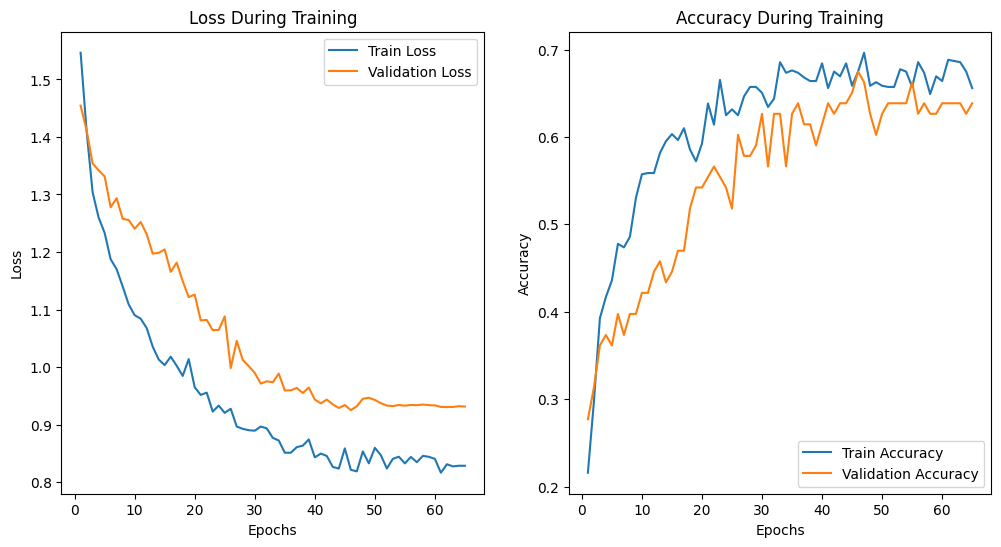

In [16]:
method_1()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Parameters Count: {'Total Parameters': 85801732, 'Trainable Parameters': 14175744}


Epoch 1: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=1.21]


Epoch 1/100 - Train Loss: 1.3915, Train Acc: 0.3171, Val Loss: 1.2782, Val Acc: 0.3373, LearningRate: 0.0003
Model saved at epoch 1


Epoch 2: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=1.25]


Epoch 2/100 - Train Loss: 1.2631, Train Acc: 0.4143, Val Loss: 1.2262, Val Acc: 0.5060, LearningRate: 0.0003
Model saved at epoch 2


Epoch 3: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=1.09]


Epoch 3/100 - Train Loss: 1.1486, Train Acc: 0.4939, Val Loss: 1.0830, Val Acc: 0.5904, LearningRate: 0.0003
Model saved at epoch 3


Epoch 4: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=1.03]


Epoch 4/100 - Train Loss: 1.0893, Train Acc: 0.5398, Val Loss: 0.9753, Val Acc: 0.5904, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 5: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=1]   


Epoch 5/100 - Train Loss: 1.0359, Train Acc: 0.5682, Val Loss: 0.9457, Val Acc: 0.5301, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 6: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=1.09]


Epoch 6/100 - Train Loss: 1.0151, Train Acc: 0.5776, Val Loss: 0.8747, Val Acc: 0.5783, LearningRate: 0.0003
Early stop counter: 3/18


Epoch 7: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.939]


Epoch 7/100 - Train Loss: 0.9362, Train Acc: 0.6181, Val Loss: 0.7312, Val Acc: 0.7831, LearningRate: 0.0003
Model saved at epoch 7


Epoch 8: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.843]


Epoch 8/100 - Train Loss: 0.8672, Train Acc: 0.6356, Val Loss: 0.6884, Val Acc: 0.7590, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 9: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.695]


Epoch 9/100 - Train Loss: 0.8280, Train Acc: 0.6694, Val Loss: 0.7520, Val Acc: 0.6747, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 10: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.839]


Epoch 10/100 - Train Loss: 0.8301, Train Acc: 0.6275, Val Loss: 0.5665, Val Acc: 0.7952, LearningRate: 0.0003
Model saved at epoch 10


Epoch 11: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.829]


Epoch 11/100 - Train Loss: 0.8070, Train Acc: 0.6815, Val Loss: 0.5137, Val Acc: 0.8675, LearningRate: 0.0003
Model saved at epoch 11


Epoch 12: 100%|██████████| 12/12 [00:15<00:00,  1.30s/batch, loss=0.739]


Epoch 12/100 - Train Loss: 0.7663, Train Acc: 0.6613, Val Loss: 0.5268, Val Acc: 0.8434, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 13: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.636]


Epoch 13/100 - Train Loss: 0.7177, Train Acc: 0.6937, Val Loss: 0.5050, Val Acc: 0.7831, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 14: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.867]


Epoch 14/100 - Train Loss: 0.7378, Train Acc: 0.7058, Val Loss: 0.5101, Val Acc: 0.8193, LearningRate: 0.0003
Early stop counter: 3/18


Epoch 15: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.616]


Epoch 15/100 - Train Loss: 0.6588, Train Acc: 0.7449, Val Loss: 0.4235, Val Acc: 0.8675, LearningRate: 0.0003
Early stop counter: 4/18


Epoch 16: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.675]


Epoch 16/100 - Train Loss: 0.6957, Train Acc: 0.6964, Val Loss: 0.4734, Val Acc: 0.8675, LearningRate: 0.0003
Early stop counter: 5/18
Learningrate changed from : 0.0003 to 0.00015


Epoch 17: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.468]


Epoch 17/100 - Train Loss: 0.6475, Train Acc: 0.7368, Val Loss: 0.4318, Val Acc: 0.8554, LearningRate: 0.00015
Early stop counter: 6/18


Epoch 18: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.471]


Epoch 18/100 - Train Loss: 0.5967, Train Acc: 0.7814, Val Loss: 0.3657, Val Acc: 0.8675, LearningRate: 0.00015
Early stop counter: 7/18


Epoch 19: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.598]


Epoch 19/100 - Train Loss: 0.5811, Train Acc: 0.7692, Val Loss: 0.3501, Val Acc: 0.8795, LearningRate: 0.00015
Model saved at epoch 19


Epoch 20: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.587]


Epoch 20/100 - Train Loss: 0.6025, Train Acc: 0.7692, Val Loss: 0.3912, Val Acc: 0.8554, LearningRate: 0.00015
Early stop counter: 1/18


Epoch 21: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.823]


Epoch 21/100 - Train Loss: 0.5743, Train Acc: 0.7773, Val Loss: 0.3582, Val Acc: 0.9036, LearningRate: 0.00015
Model saved at epoch 21


Epoch 22: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.534]


Epoch 22/100 - Train Loss: 0.5625, Train Acc: 0.7719, Val Loss: 0.3856, Val Acc: 0.8675, LearningRate: 0.00015
Early stop counter: 1/18


Epoch 23: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.632]


Epoch 23/100 - Train Loss: 0.5460, Train Acc: 0.8030, Val Loss: 0.3468, Val Acc: 0.9398, LearningRate: 0.00015
Model saved at epoch 23


Epoch 24: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.483]


Epoch 24/100 - Train Loss: 0.5593, Train Acc: 0.7557, Val Loss: 0.3788, Val Acc: 0.8795, LearningRate: 0.00015
Early stop counter: 1/18


Epoch 25: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.517]


Epoch 25/100 - Train Loss: 0.5010, Train Acc: 0.8151, Val Loss: 0.3446, Val Acc: 0.8916, LearningRate: 0.00015
Early stop counter: 2/18


Epoch 26: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.656]


Epoch 26/100 - Train Loss: 0.4987, Train Acc: 0.8111, Val Loss: 0.3531, Val Acc: 0.8795, LearningRate: 0.00015
Early stop counter: 3/18


Epoch 27: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.544]


Epoch 27/100 - Train Loss: 0.5161, Train Acc: 0.7949, Val Loss: 0.3170, Val Acc: 0.9277, LearningRate: 0.00015
Early stop counter: 4/18


Epoch 28: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.488]


Epoch 28/100 - Train Loss: 0.5254, Train Acc: 0.7827, Val Loss: 0.3344, Val Acc: 0.9157, LearningRate: 0.00015
Early stop counter: 5/18
Learningrate changed from : 0.00015 to 7.5e-05


Epoch 29: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.612]


Epoch 29/100 - Train Loss: 0.5145, Train Acc: 0.7841, Val Loss: 0.3218, Val Acc: 0.9036, LearningRate: 7.5e-05
Early stop counter: 6/18


Epoch 30: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.57] 


Epoch 30/100 - Train Loss: 0.4910, Train Acc: 0.8097, Val Loss: 0.2945, Val Acc: 0.9157, LearningRate: 7.5e-05
Early stop counter: 7/18


Epoch 31: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.42] 


Epoch 31/100 - Train Loss: 0.5136, Train Acc: 0.7814, Val Loss: 0.3148, Val Acc: 0.9036, LearningRate: 7.5e-05
Early stop counter: 8/18


Epoch 32: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.522]


Epoch 32/100 - Train Loss: 0.4856, Train Acc: 0.8111, Val Loss: 0.3316, Val Acc: 0.8795, LearningRate: 7.5e-05
Early stop counter: 9/18


Epoch 33: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.408]


Epoch 33/100 - Train Loss: 0.4809, Train Acc: 0.8097, Val Loss: 0.3301, Val Acc: 0.8795, LearningRate: 7.5e-05
Early stop counter: 10/18
Learningrate changed from : 7.5e-05 to 3.75e-05


Epoch 34: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.468]


Epoch 34/100 - Train Loss: 0.4515, Train Acc: 0.8273, Val Loss: 0.3143, Val Acc: 0.8916, LearningRate: 3.75e-05
Early stop counter: 11/18


Epoch 35: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.862]


Epoch 35/100 - Train Loss: 0.4673, Train Acc: 0.8138, Val Loss: 0.3112, Val Acc: 0.8916, LearningRate: 3.75e-05
Early stop counter: 12/18


Epoch 36: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.519]


Epoch 36/100 - Train Loss: 0.4583, Train Acc: 0.8286, Val Loss: 0.3125, Val Acc: 0.9036, LearningRate: 3.75e-05
Early stop counter: 13/18


Epoch 37: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.515]


Epoch 37/100 - Train Loss: 0.4435, Train Acc: 0.8300, Val Loss: 0.3159, Val Acc: 0.9036, LearningRate: 3.75e-05
Early stop counter: 14/18


Epoch 38: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.497]


Epoch 38/100 - Train Loss: 0.4660, Train Acc: 0.8124, Val Loss: 0.2988, Val Acc: 0.9157, LearningRate: 3.75e-05
Early stop counter: 15/18
Learningrate changed from : 3.75e-05 to 1.875e-05


Epoch 39: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.473]


Epoch 39/100 - Train Loss: 0.4540, Train Acc: 0.8165, Val Loss: 0.2988, Val Acc: 0.9036, LearningRate: 1.875e-05
Early stop counter: 16/18


Epoch 40: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.522]


Epoch 40/100 - Train Loss: 0.4316, Train Acc: 0.8327, Val Loss: 0.3148, Val Acc: 0.9036, LearningRate: 1.875e-05
Early stop counter: 17/18


Epoch 41: 100%|██████████| 12/12 [00:15<00:00,  1.29s/batch, loss=0.392]


Epoch 41/100 - Train Loss: 0.4469, Train Acc: 0.8286, Val Loss: 0.3145, Val Acc: 0.8916, LearningRate: 1.875e-05
Early stop counter: 18/18


Epoch 42: 100%|██████████| 12/12 [00:15<00:00,  1.28s/batch, loss=0.506]


Epoch 42/100 - Train Loss: 0.4141, Train Acc: 0.8516, Val Loss: 0.2855, Val Acc: 0.9157, LearningRate: 1.875e-05
Early stop counter: 19/18
Early stopping triggered!


<ipython-input-14-1c4be24b5e22>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))  # Load the best model


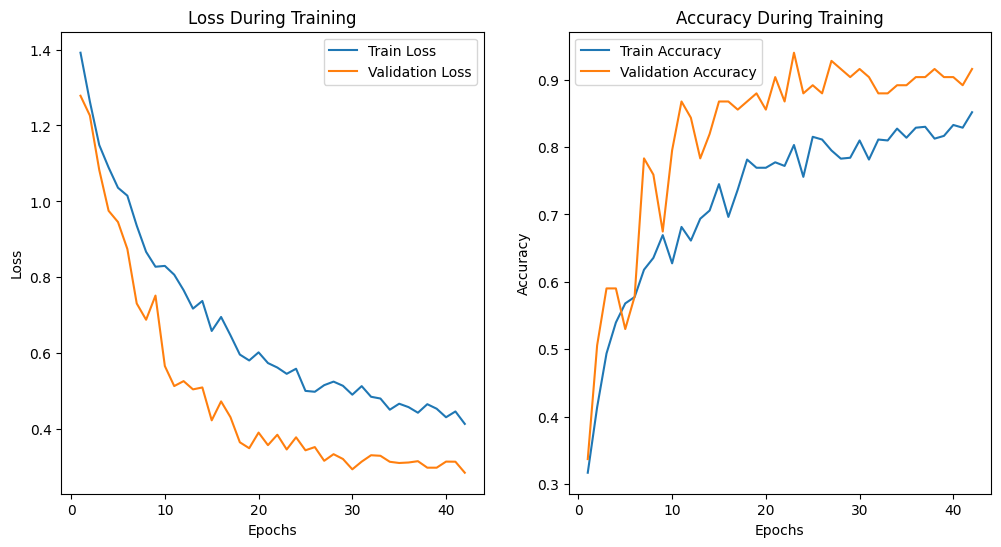

In [17]:
method_2()

In [ ]:
method_3()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Parameters Count: {'Total Parameters': 85801732, 'Trainable Parameters': 14175744}


Epoch 1: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=1]   


Epoch 1/100 - Train Loss: 1.2599, Train Acc: 0.4035, Val Loss: 1.1930, Val Acc: 0.4217, LearningRate: 0.0003
Model saved at epoch 1


Epoch 2: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.838]


Epoch 2/100 - Train Loss: 1.0366, Train Acc: 0.5587, Val Loss: 0.8601, Val Acc: 0.7108, LearningRate: 0.0003
Model saved at epoch 2


Epoch 3: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.826]


Epoch 3/100 - Train Loss: 0.8074, Train Acc: 0.6626, Val Loss: 0.5483, Val Acc: 0.7470, LearningRate: 0.0003
Model saved at epoch 3


Epoch 4: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.578]


Epoch 4/100 - Train Loss: 0.7231, Train Acc: 0.6950, Val Loss: 0.3687, Val Acc: 0.8554, LearningRate: 0.0003
Model saved at epoch 4


Epoch 5: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.549]


Epoch 5/100 - Train Loss: 0.6447, Train Acc: 0.7355, Val Loss: 0.3106, Val Acc: 0.8675, LearningRate: 0.0003
Model saved at epoch 5


Epoch 6: 100%|██████████| 12/12 [00:11<00:00,  1.05batch/s, loss=0.502]


Epoch 6/100 - Train Loss: 0.5746, Train Acc: 0.7625, Val Loss: 0.3568, Val Acc: 0.8554, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 7: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.534]


Epoch 7/100 - Train Loss: 0.5732, Train Acc: 0.7530, Val Loss: 0.3798, Val Acc: 0.8313, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 8: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.719]


Epoch 8/100 - Train Loss: 0.5865, Train Acc: 0.7517, Val Loss: 0.2712, Val Acc: 0.8795, LearningRate: 0.0003
Model saved at epoch 8


Epoch 9: 100%|██████████| 12/12 [00:11<00:00,  1.05batch/s, loss=0.542]


Epoch 9/100 - Train Loss: 0.5456, Train Acc: 0.7611, Val Loss: 0.2447, Val Acc: 0.8795, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 10: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.541]


Epoch 10/100 - Train Loss: 0.5210, Train Acc: 0.7827, Val Loss: 0.2296, Val Acc: 0.9036, LearningRate: 0.0003
Model saved at epoch 10


Epoch 11: 100%|██████████| 12/12 [00:11<00:00,  1.07batch/s, loss=0.352]


Epoch 11/100 - Train Loss: 0.4767, Train Acc: 0.7989, Val Loss: 0.2200, Val Acc: 0.9157, LearningRate: 0.0003
Model saved at epoch 11


Epoch 12: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.457]


Epoch 12/100 - Train Loss: 0.4725, Train Acc: 0.8057, Val Loss: 0.2423, Val Acc: 0.9036, LearningRate: 0.0003
Early stop counter: 1/18


Epoch 13: 100%|██████████| 12/12 [00:11<00:00,  1.06batch/s, loss=0.394]


Epoch 13/100 - Train Loss: 0.4382, Train Acc: 0.8151, Val Loss: 0.2383, Val Acc: 0.9157, LearningRate: 0.0003
Early stop counter: 2/18


Epoch 14: 100%|██████████| 12/12 [00:11<00:00,  1.04batch/s, loss=0.351]


Epoch 14/100 - Train Loss: 0.4423, Train Acc: 0.8111, Val Loss: 0.2670, Val Acc: 0.8916, LearningRate: 0.0003
Early stop counter: 3/18


  0%|          | 0/12 [00:00<?, ?batch/s]

In [ ]:
method_4()

In [ ]:
densenet = models.densenet121(pretrained=True)
num_classes = len(CELL_TYPES)  
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
densenet = densenet.to(device)

for param in densenet.parameters():
        param.requires_grad = True

model_params_count = count_model_parameters(densenet)
print("Model Parameters Count:", model_params_count)
    
train_model(
    densenet, train_loader, val_loader, 
    epochs=100, learning_rate=3e-4, 
    dataset=dataset, model_name="CNN",
    patience=18, scheduler_patience=5, 
    save_path="best_CNN.pth"
)

In [ ]:
densenet = models.densenet121(pretrained=True)
num_classes = len(CELL_TYPES)  
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
densenet = densenet.to(device)

for param in densenet.parameters():
        param.requires_grad = False
for param in densenet.classifier.parameters():
        param.requires_grad = True

model_params_count = count_model_parameters(densenet)
print("Model Parameters Count:", model_params_count)
    
train_model(
    densenet, train_loader, val_loader, 
    epochs=100, learning_rate=3e-4, 
    dataset=dataset, model_name="CNN",
    patience=18, scheduler_patience=5, 
    save_path="best_CNN.pth"
)